As Explained in **"Introduction to SparkML"** Reading and Processing the HMP Dataset. In this section, we'll fit a Linear Regression Model with SparkML on the Data. **Warning:** this Data is not for Linear Regression, but can be used for Classification Purpose. However, for the sake of simple understanding of Linear Regression, we try and fit the Model.

In [1]:
!git clone https://github.com/wchill/HMP_Dataset

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20200602182839-0000
KERNEL_ID = c3a09eee-150e-4fda-9f23-49eb9b0b325d
Cloning into 'HMP_Dataset'...
remote: Enumerating objects: 865, done.
remote: Total 865 (delta 0), reused 0 (delta 0), pack-reused 865
Receiving objects: 100% (865/865), 1010.96 KiB | 0 bytes/s, done.
Checking out files: 100% (848/848), done.


In [51]:
%matplotlib inline

In [59]:
import time
import glob

import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import lit
from pyspark.ml.regression import LinearRegression

from pyspark import (
        SparkConf,
        SparkContext
    )
from pyspark.sql.types import (
        StructType,
        StructField,
        IntegerType
    )

from pyspark.ml.feature import (
        Normalizer,
        StringIndexer,
        OneHotEncoder,
        VectorAssembler
    )

In [3]:
HMPSchema = StructType((
        StructField('x', IntegerType(), nullable = True),
        StructField('y', IntegerType(), nullable = True),
        StructField('z', IntegerType(), nullable = True)
    ))

In [4]:
folderList = [i for i in os.listdir('HMP_Dataset') if '.' not in i]

In [8]:
data = None

for category in folderList:
    print(f'[{time.ctime()}] Reading Category : {category}')
    for dataFile in glob.glob(f'HMP_Dataset/{category}/*.txt'):
        _temp = spark.read.option('header', 'false').option('delimiter', ' ').csv(dataFile, schema = HMPSchema)
        
        # Adding the Category & Source-File Information into the Temporary Created DataFrame
        _temp = _temp.withColumn('class', lit(category))
        _temp = _temp.withColumn('source', lit(dataFile))
        
        if data is None:
            data = _temp # Add the Data, for the First Iteration
        else:
            data = data.union(_temp)

[Tue Jun  2 18:30:10 2020] Reading Category : Brush_teeth
[Tue Jun  2 18:30:15 2020] Reading Category : Climb_stairs
[Tue Jun  2 18:30:24 2020] Reading Category : Comb_hair
[Tue Jun  2 18:30:27 2020] Reading Category : Descend_stairs
[Tue Jun  2 18:30:31 2020] Reading Category : Drink_glass
[Tue Jun  2 18:30:40 2020] Reading Category : Eat_meat
[Tue Jun  2 18:30:41 2020] Reading Category : Eat_soup
[Tue Jun  2 18:30:41 2020] Reading Category : Getup_bed
[Tue Jun  2 18:30:51 2020] Reading Category : Liedown_bed
[Tue Jun  2 18:30:54 2020] Reading Category : Pour_water
[Tue Jun  2 18:31:05 2020] Reading Category : Sitdown_chair
[Tue Jun  2 18:31:17 2020] Reading Category : Standup_chair
[Tue Jun  2 18:31:30 2020] Reading Category : Use_telephone
[Tue Jun  2 18:31:32 2020] Reading Category : Walk


In [9]:
data.show()

+---+---+---+-----------+--------------------+
|  x|  y|  z|      class|              source|
+---+---+---+-----------+--------------------+
| 22| 49| 35|Brush_teeth|HMP_Dataset/Brush...|
| 22| 49| 35|Brush_teeth|HMP_Dataset/Brush...|
| 22| 52| 35|Brush_teeth|HMP_Dataset/Brush...|
| 22| 52| 35|Brush_teeth|HMP_Dataset/Brush...|
| 21| 52| 34|Brush_teeth|HMP_Dataset/Brush...|
| 22| 51| 34|Brush_teeth|HMP_Dataset/Brush...|
| 20| 50| 35|Brush_teeth|HMP_Dataset/Brush...|
| 22| 52| 34|Brush_teeth|HMP_Dataset/Brush...|
| 22| 50| 34|Brush_teeth|HMP_Dataset/Brush...|
| 22| 51| 35|Brush_teeth|HMP_Dataset/Brush...|
| 21| 51| 33|Brush_teeth|HMP_Dataset/Brush...|
| 20| 50| 34|Brush_teeth|HMP_Dataset/Brush...|
| 21| 49| 33|Brush_teeth|HMP_Dataset/Brush...|
| 21| 49| 33|Brush_teeth|HMP_Dataset/Brush...|
| 20| 51| 35|Brush_teeth|HMP_Dataset/Brush...|
| 18| 49| 34|Brush_teeth|HMP_Dataset/Brush...|
| 19| 48| 34|Brush_teeth|HMP_Dataset/Brush...|
| 16| 53| 34|Brush_teeth|HMP_Dataset/Brush...|
| 18| 52| 35|

In [18]:
data.createOrReplaceTempView('data')

In [22]:
EnergyCalculation = spark.sql("""
SELECT SQRT(SUM(x * x)) + SQRT(SUM(y * y)) + SQRT(SUM(z * z)) AS TotalEnergy, class FROM data GROUP BY class
""")

EnergyCalculation.take(5)

[Row(TotalEnergy=15410.039149095397, class='Use_telephone'),
 Row(TotalEnergy=16322.870852552724, class='Standup_chair'),
 Row(TotalEnergy=21362.120691370405, class='Eat_meat'),
 Row(TotalEnergy=22408.838936599815, class='Getup_bed'),
 Row(TotalEnergy=25760.81544062919, class='Drink_glass')]

In [29]:
EnergyCalculation.createOrReplaceTempView('EnergyCalculation')

In [39]:
FinalData = spark.sql("""
SELECT x, y, z, data.class AS class, TotalEnergy AS label FROM data INNER JOIN EnergyCalculation ON data.class = EnergyCalculation.class
""")

FinalData.show() # NOTE : label is Default-Column while fitting a SparkML Model

+---+---+---+-----------+----------------+
|  x|  y|  z|      class|           label|
+---+---+---+-----------+----------------+
| 22| 49| 35|Brush_teeth|19917.7077252724|
| 22| 49| 35|Brush_teeth|19917.7077252724|
| 22| 52| 35|Brush_teeth|19917.7077252724|
| 22| 52| 35|Brush_teeth|19917.7077252724|
| 21| 52| 34|Brush_teeth|19917.7077252724|
| 22| 51| 34|Brush_teeth|19917.7077252724|
| 20| 50| 35|Brush_teeth|19917.7077252724|
| 22| 52| 34|Brush_teeth|19917.7077252724|
| 22| 50| 34|Brush_teeth|19917.7077252724|
| 22| 51| 35|Brush_teeth|19917.7077252724|
| 21| 51| 33|Brush_teeth|19917.7077252724|
| 20| 50| 34|Brush_teeth|19917.7077252724|
| 21| 49| 33|Brush_teeth|19917.7077252724|
| 21| 49| 33|Brush_teeth|19917.7077252724|
| 20| 51| 35|Brush_teeth|19917.7077252724|
| 18| 49| 34|Brush_teeth|19917.7077252724|
| 19| 48| 34|Brush_teeth|19917.7077252724|
| 16| 53| 34|Brush_teeth|19917.7077252724|
| 18| 52| 35|Brush_teeth|19917.7077252724|
| 18| 51| 32|Brush_teeth|19917.7077252724|
+---+---+--

In [34]:
assembler = VectorAssembler(inputCols = 'x y z'.split(), outputCol = "features")
StdScalar = Normalizer(inputCol = 'features', outputCol = 'NormalizedFeatures', p = 1.0)

In [35]:
linReg = LinearRegression(maxIter = 10, regParam = 0.3, elasticNetParam = 0.8)

In [37]:
LinRegModel = Pipeline(stages = [
    assembler, # Assemble Data as Vector Objects
    StdScalar, # Scaling the Data, i.e. Normalization
    linReg     # Linear Regression Model
])

In [40]:
model      = LinRegModel.fit(FinalData)
prediction = model.transform(FinalData)

In [49]:
# Now we can get the Model Summary as Follows
print(f'R-Squared               : {round(model.stages[2].summary.r2, 5)}')
print(f'Adjusted R-Squared      : {round(model.stages[2].summary.r2adj, 5)}')
print(f'Mean Squared Error      : {round(model.stages[2].summary.meanSquaredError, 5)}')
print(f'Mean Absolute Error     : {round(model.stages[2].summary.meanAbsoluteError, 5)}')
print(f'Root Mean Squared Error : {round(model.stages[2].summary.rootMeanSquaredError, 5)}')

R-Squared               : 0.01877
Adjusted R-Squared      : 0.01876
Mean Squared Error      : 21593402.54917
Mean Absolute Error     : 3914.54636
Root Mean Squared Error : 4646.87019


In [57]:
x = FinalData.rdd.map(lambda cols : cols[0]).collect()
y = FinalData.rdd.map(lambda cols : cols[1]).collect()
z = FinalData.rdd.map(lambda cols : cols[2]).collect()

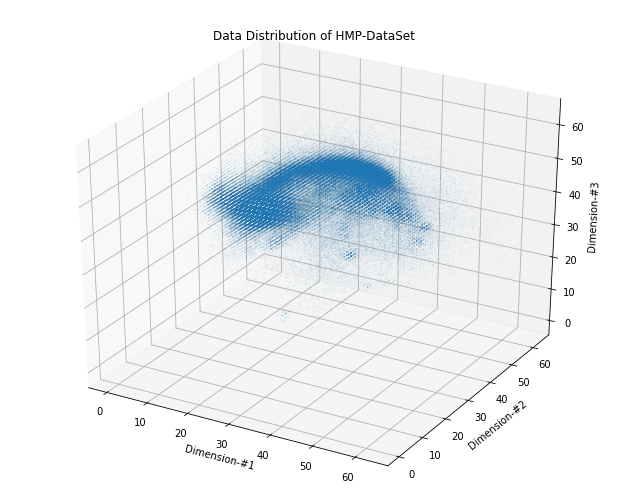

In [61]:
fig = plt.figure(figsize = (11, 9))
axs = fig.add_subplot(111, projection = '3d')

axs.scatter(x, y, z, marker = 'o', s = 0.001)

axs.set_xlabel('Dimension-#1')
axs.set_ylabel('Dimension-#2')
axs.set_zlabel('Dimension-#3')

axs.set_title('Data Distribution of HMP-DataSet')

plt.show()